In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.io import savemat    
from pypoman.projection import project_polytope

# Visual check fof feasibility

In [175]:
def calculate_u_l(p_min, p_max, e_min, e_max, del_t, t_steps):
    u = [0]
    l = [0]
    for n in range(1, t_steps+1):
        u.append(min(n*del_t*p_max, e_max-(t_steps-n)*del_t*p_min))
        l.append(max(n*del_t*p_min, e_min-(t_steps-n)*del_t*p_max))
    return u, l

def generate_combinations_matrix(n):
    matrix_total = []
    for i in range(1, n+1):
        combinations_list = list(combinations(range(n), i))
        matrix = np.zeros((len(combinations_list), n), dtype=int)

        for row, comb in enumerate(combinations_list):
            for element in comb:
                matrix[row, element] = 1

        matrix_total.append(matrix)

    return np.vstack(matrix_total)

def bmatrix(a):
    text = r'$\left[\begin{array}{*{'
    text += str(len(a[0]))
    text += r'}c}'
    text += '\n'
    for x in range(len(a)):
        for y in range(len(a[x])):
            text += str(a[x][y])
            text += r' & '
        text = text[:-2]
        text += r'\\'
        text += '\n'
    text += r'\end{array}\right]$'
    print(text)
    
def generate_polytope_b_matrix(T):
   mymatrix = []
   for col in range(1,1+T):
      c_m = []
      for row in range(1,1+T):
         if row == col:
            c_m.append(np.ones(shape=(len(list(combinations(range(T), row))),1), dtype=int))
         else:
            c_m.append(np.zeros(shape=(len(list(combinations(range(T), row))),1), dtype=int))

      single_col_matrix = np.vstack(c_m)
   
      mymatrix.append(single_col_matrix)

   return np.hstack(mymatrix)

def plot_feasibility_test(u,l,p_feasible, p_infeasible, fsize=(20,10),save_path=None):
    ''' This function plots the feasibility test for the given upper and lower limits of a EV for a provided feasible and infeasible power profile. C.F. Lemma 1 (Ordered UL repreentation) in the paper.
    param u: upper limit of the EV
    param l: lower limit of the EV
    param p_feasible: feasible power profile
    param p_infeasible: infeasible power profile
    param fsize: figure size
    param save_path: path to save the figure
    return: None
    '''
    t_steps = len(u)
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(1,2,figsize=fsize, sharey=True)
    plt.subplots_adjust(wspace=0.05)

    ax[0].plot(np.arange(t_steps),u, marker='o', label=r'$\vec{u}$', color='red',linewidth=2) # UPPER LIMIT
    ax[0].plot(np.arange(t_steps),l, marker='o', label=r'$\vec{l}$', color='red', linestyle='--',linewidth=2) # LOWER LIMIT
    p_up = [0] + list(np.cumsum(np.sort(p_feasible)[::-1]))  # sort decending Integral of descending
    p_low = [0] + list(np.cumsum(np.sort(p_feasible)) ) # sort ascending  INTEGRAL OF ASCENDING
    ax[0].plot(np.arange(t_steps),p_up, marker='o', label=r'$\sum_k$ descending $(\vec{p}_k)$', color='blue',linewidth=2)
    ax[0].plot(np.arange(t_steps),p_low, marker='o', label=r'$\sum_k$ ascending $(\vec{p}_k)$', color='blue', linestyle='--',linewidth=2)
    ax[0].set_xticks(np.arange(t_steps))
    ax[0].set_xlabel('time intervals ($k$)')
    ax[0].set_ylabel('Energy (kWh)')
    # ax[0].text(0.75, 0.8,r'$\vec{p}$='+str(p_feasible)+ ' kW', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
    ax[0].grid(linewidth=0.5 )


    ax[1].plot(np.arange(t_steps),u, marker='o', label=r'$\vec{u}$', color='red',linewidth=2)
    ax[1].plot(np.arange(t_steps),l, marker='o', label=r'$\vec{l}$', color='red', linestyle='--',linewidth=2)
    p_up = [0] +list(np.cumsum(np.sort(p_infeasible)[::-1]))  # sort decending
    p_low =[0] + list(np.cumsum(np.sort(p_infeasible)))  # sort ascending
    ax[1].plot(np.arange(t_steps),p_up, marker='o', label=r'descending $\vec{p}$', color='blue',linewidth=2)
    ax[1].plot(np.arange(t_steps),p_low, marker='o', label=r'ascending $\vec{p}$', color='blue', linestyle='--',linewidth=2)
    ax[1].set_xticks(np.arange(t_steps))
    ax[1].set_xlabel('time intervals ($k$)')
    # ax[1].text(0.75, 0.08,r'$\vec{p}$='+str(p_infeasible)+ ' kW', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
    ax[1].grid(linewidth=0.5 )


    # Annotate infeasible point
    # Find the index where p_up is more than u or p_low is less than l


    inf_index_low= np.where((np.array(p_low)<np.array(l)))
    inf_index_up = np.where((np.array(p_up)>np.array(u)))
    for i in inf_index_low[0]:
        ax[1].annotate('Infeasible', xy=(i, p_low[i]), xytext=(i, p_low[i]+2),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
    for i in inf_index_up[0]:
        ax[1].annotate('Infeasible', xy=(i, p_up[i]), xytext=(i+0.5, p_up[i]-2),
                arrowprops=dict(facecolor='black', shrink=0.04, width=1, headwidth=6),
                )
        ax[1].scatter(i, p_up[i], marker='*', color='m', s=330, zorder=10)

    #make a single legend for the figure
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=4)

    plt.rcParams.update({'font.size': 12})
    a = plt.axes([.145, .77, .12, .1])
    plt.step(np.arange(t_steps+1),[0]+list(p_feasible) + [p_feasible[-1]], label=r'Feasible $\vec{p}$', color='green',where='post', linewidth=2)
    # plt.text(0.245, 0.88,r'$\vec{p}$='+str(p_feasible)+ ' kW', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
    plt.xticks(np.arange(t_steps))
    # y-grid only
    plt.grid(axis='y', linestyle='--', linewidth=1)

    b = plt.axes([.54, .77, .12, .1])
    plt.step(np.arange(t_steps+1),[0]+list(p_infeasible) + [p_infeasible[-1]], label=r'Feasible $\vec{p}$', color='green',where='post', linewidth=2)
    plt.xticks(np.arange(t_steps))
    plt.grid(axis='y', linestyle='--', linewidth=1)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    return None





## UL vectors for individual EVs

In [176]:
t_steps = 3
u1,l1 = calculate_u_l(p_max=20, p_min=0, e_min = 15, e_max=25, del_t=1, t_steps=3)
u2, l2 = calculate_u_l(p_max=10, p_min=5, e_min = 20, e_max=30, del_t=1, t_steps=3)
print(f'The U vector for EV#1 is: {u1}\n The L vector for EV#1 is: {l1}')
print(f'The U vector for EV#2 is: {u2}\n The L vector for EV#2 is: {l2}')

The U vector for EV#1 is: [0, 20, 25, 25]
 The L vector for EV#1 is: [0, 0, 0, 15]
The U vector for EV#2 is: [0, 10, 20, 30]
 The L vector for EV#2 is: [0, 5, 10, 20]


## Polytope

In [177]:
T = 3
# Vector A
A = generate_combinations_matrix(T)
# print side by side
print(f'The matrix A for T = {T} is:')
bmatrix(A) 

b = generate_polytope_b_matrix(T)
print(f'The matrix b for T = {T} is:')
bmatrix(b)

A_poly = np.vstack([A, -A])
b_poly1 = np.vstack([np.matmul(b,np.array(u1[1:])).reshape((len(b),1)),-np.matmul(b,np.array(l1[1:])).reshape((len(b),1))])
b_poly2 = np.vstack([np.matmul(b,np.array(u2[1:])).reshape((len(b),1)),-np.matmul(b,np.array(l2[1:])).reshape((len(b),1))])

print(f'The matrix A_poly for T = {T} is:')
bmatrix(A_poly)
print(f'The matrix b_poly of Polytope 1 for T = {T} is:')
bmatrix(b_poly1)
print('##################')
print(f'The matrix b_poly of Polytope 2 for T = {T} is:')
bmatrix(b_poly2)


# Saving A, B as  .mat file for plotting

savemat('polytope_matrix.mat', {'A':A_poly, 'B1':b_poly1, 'B2':b_poly2})
print(f'System matrix saved as polytope_matrix.mat')

The matrix A for T = 3 is:
$\left[\begin{array}{*{3}c}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 1 & 0 \\
1 & 0 & 1 \\
0 & 1 & 1 \\
1 & 1 & 1 \\
\end{array}\right]$
The matrix b for T = 3 is:
$\left[\begin{array}{*{3}c}
1 & 0 & 0 \\
1 & 0 & 0 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
\end{array}\right]$
The matrix A_poly for T = 3 is:
$\left[\begin{array}{*{3}c}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 1 & 0 \\
1 & 0 & 1 \\
0 & 1 & 1 \\
1 & 1 & 1 \\
-1 & 0 & 0 \\
0 & -1 & 0 \\
0 & 0 & -1 \\
-1 & -1 & 0 \\
-1 & 0 & -1 \\
0 & -1 & -1 \\
-1 & -1 & -1 \\
\end{array}\right]$
The matrix b_poly of Polytope 1 for T = 3 is:
$\left[\begin{array}{*{1}c}
20 \\
20 \\
20 \\
25 \\
25 \\
25 \\
25 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
-15 \\
\end{array}\right]$
##################
The matrix b_poly of Polytope 2 for T = 3 is:
$\left[\begin{array}{*{1}c}
10 \\
10 \\
10 \\
20 \\
20 \\
20 \\
30 \\
-5 \\
-5 \\
-5 \\
-10 \\
-10 \\
-10 \\
-20 \\
\end{array}\right]$
System matrix saved 

## Feasible signal

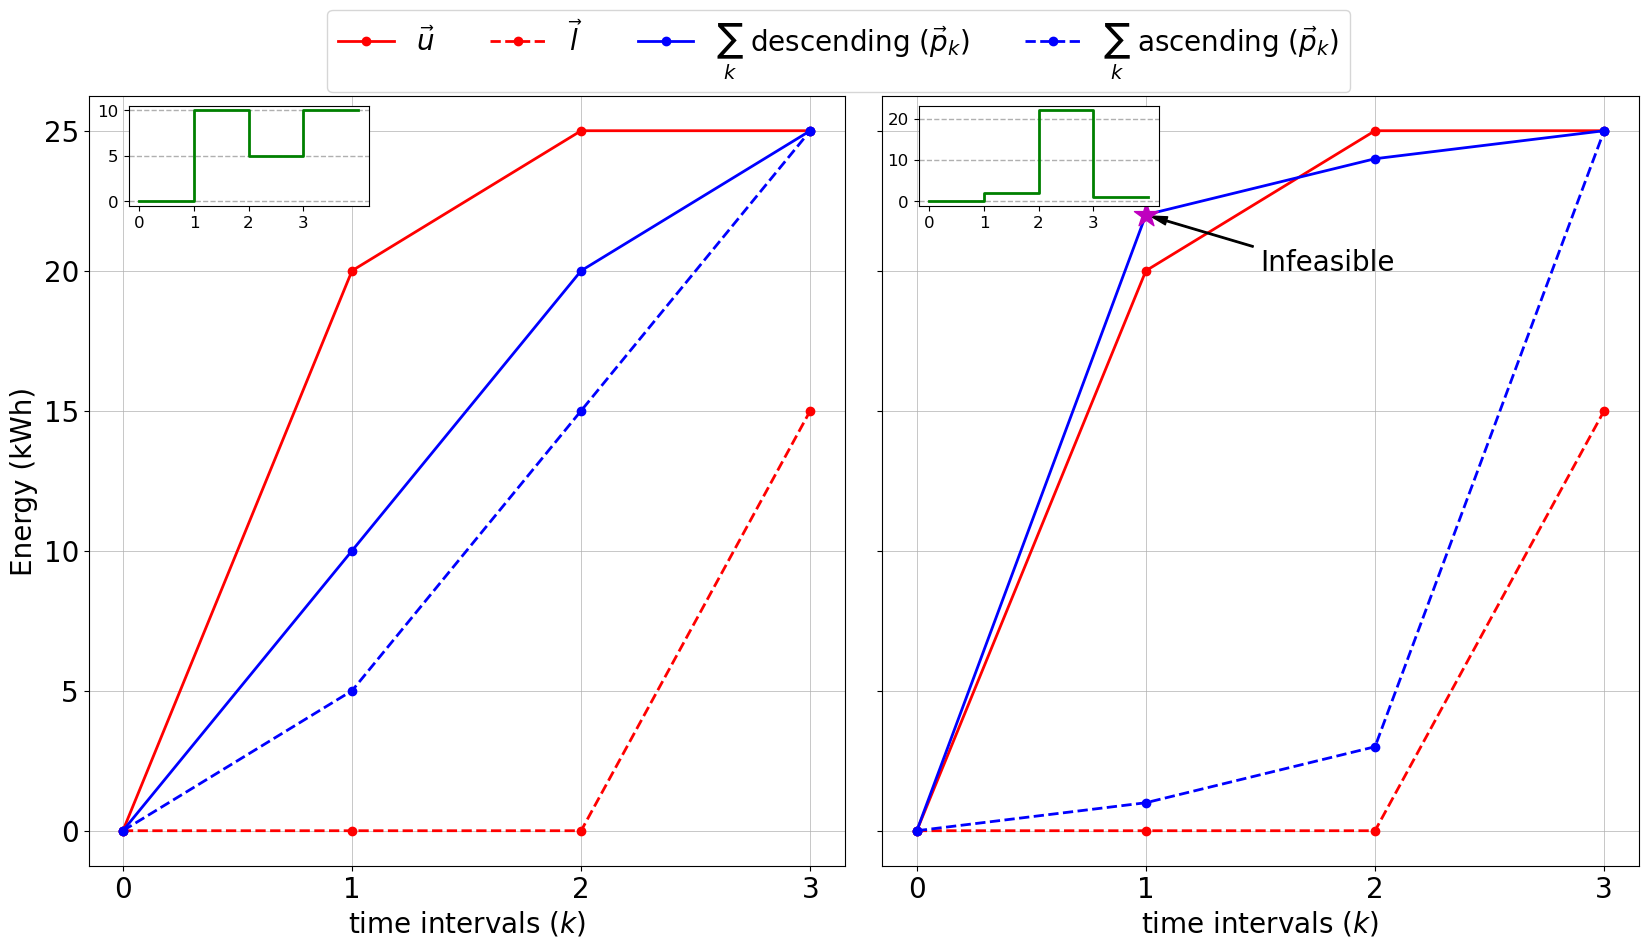

In [178]:
u, l = calculate_u_l(p_max=20, p_min=0, e_min = 15, e_max=25, del_t=1, t_steps=3)
p_feasible = [10,5,10]
p_infeasible = [2,22,1]

plot_feasibility_test(u,l,p_feasible,p_infeasible,save_path='figures/graphical_test.png')